#### Paquetes necesarios

In [65]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

#### Carga imagen y convierte a RGB

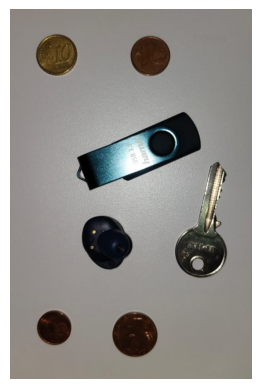

In [66]:
# Carga imagen ejemplo con monedas
img = cv2.imread('Images/monedas-objetos-1.jpg') 

# OpenCV lee las imágenes en BGR, por lo que convertimos para visualizar RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

#### Conversión a gris y muestra histograma

(0.0, 256.0)

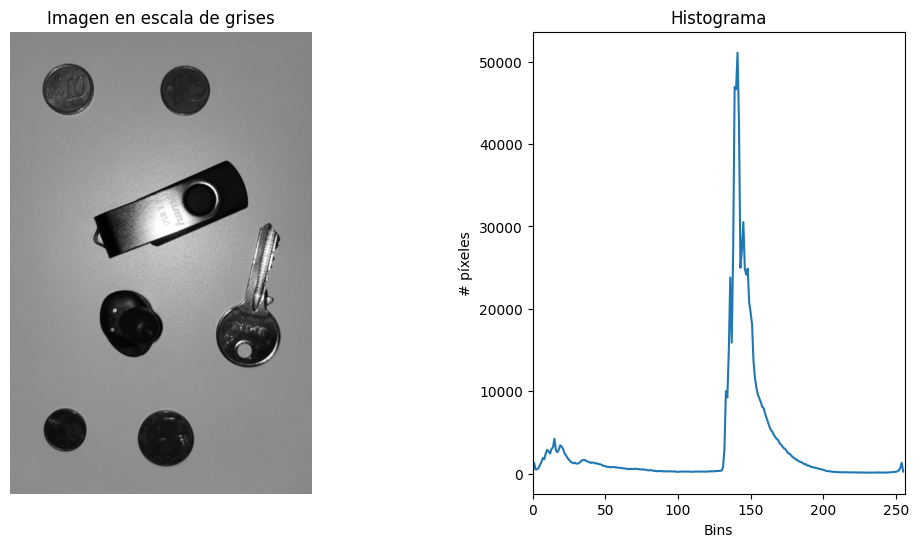

In [67]:
# Convierte la imagen a tonos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

# Creación de la figura
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(wspace=0.5) 

# Imagen en tonos de gris
plt.subplot(1, 2, 1)
plt.title("Imagen en escala de grises")
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])

#### Umbralización de la imagen

Text(0.5, 1.0, 'FIJO invertida')

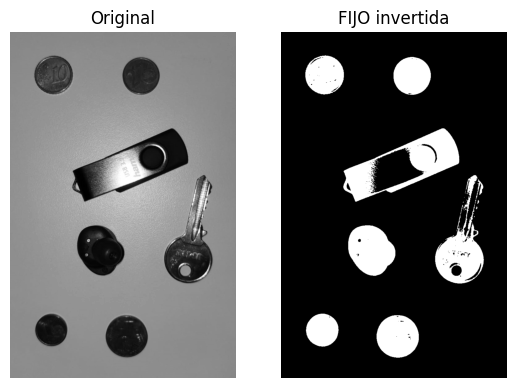

In [68]:
# Umbralización con valor de umbral fijo
umbral = 115
# Umbralizado binaria invertido, dado que por defecto se asume objetos en blanco
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

#### Búsqueda de contornos básica

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Número total de monedas:  4


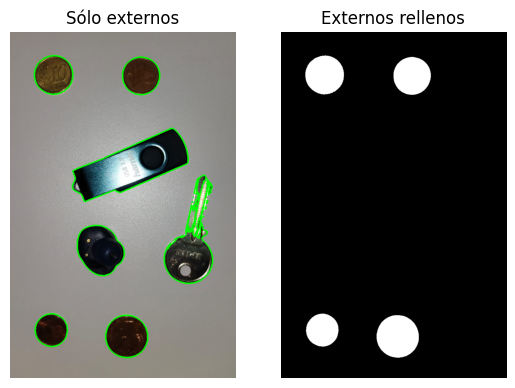

In [69]:
#Obtiene todos los contornos, externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, # Imagen
    cv2.RETR_TREE, # Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE # Método de aproximación del contorno
    )

# Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

# Variable para contar el número de monedas
monedas_totales = 0

# Imagen negra sobre la que se dibujarán los contornos
img_cont = np.zeros(img_rgb.shape)

for c in contornos2:
    # Área del contorno
    area = cv2.contourArea(c)

    # Perímetro del contorno
    perimetro = cv2.arcLength(c, True)

    # Contenedor alineado con ejes de la imagen
    x, y, w, h = cv2.boundingRect(c)

    # Mínimo contenedor ajustado para el contorno
    rect = cv2.minAreaRect(c)

    # Mínimo círculo que lo contiene
    (cx, cy), radio = cv2.minEnclosingCircle(c)

    # Calcula el área de un círculo ideal con el radio del mínimo círculo
    area_circulo_ideal = np.pi * (radio ** 2)

    # Umbral para la comparación del área del contorno y el área del círculo ideal
    umbral_area = 0.9  

    # Calcula la relación de aspecto
    relacion_aspecto = w / h

    # Umbral para la relación de aspecto
    umbral_aspecto = 0.9  

    # Verifica si el contorno se asemeja a un círculo
    if (area / area_circulo_ideal > umbral_area) and np.isclose(relacion_aspecto, 1.0, rtol=umbral_aspecto):
        # Dibuja el contorno en la imagen
        cv2.drawContours(img_cont, [c], -1, (255, 255, 255), -1)

        # Incrementa el contador de monedas
        monedas_totales += 1

# Número total de monedas
print("\nNúmero total de monedas: ", monedas_totales)

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()

#### Aplicación de la Transformada de Hough para la detección de monedas

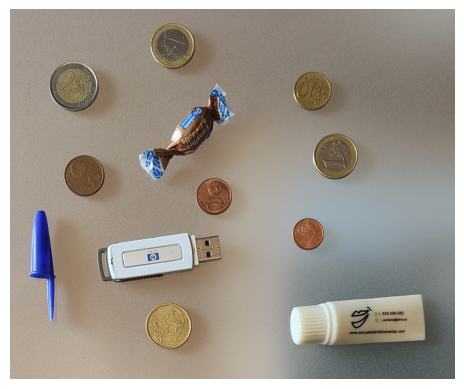

In [73]:
# Nueva imagen con monedas y objetos
img_hough = cv2.imread('Images/monedas-objetos-2.jpg') 

# OpenCV lee las imágenes en BGR, por lo que convertimos para visualizar RGB
img_hough_rgb = cv2.cvtColor(img_hough, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_hough_rgb) 
plt.show()

#### Detección de monedas entre objetos con Hough

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Número total de monedas:  8


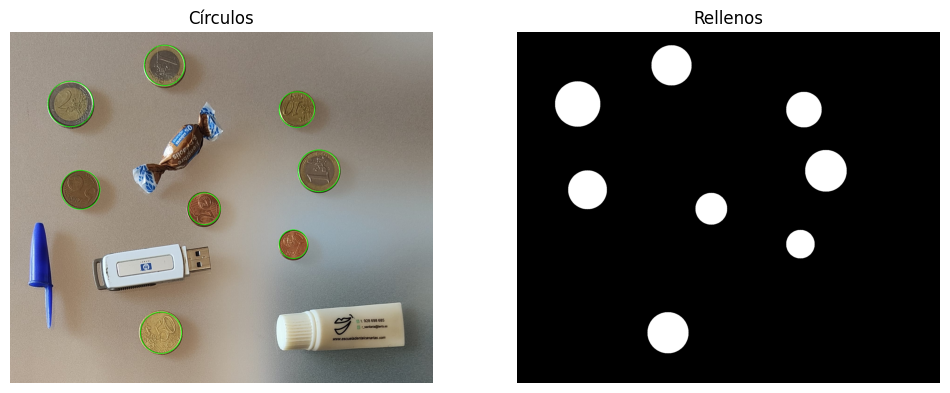

In [74]:
# Conversión a gris
gris = cv2.cvtColor(img_hough_rgb, cv2.COLOR_RGB2GRAY)

# Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)

# Localiza círculos
circ = cv2.HoughCircles(
        pimg,  # Imagen 
        cv2.HOUGH_GRADIENT,  # Tipo de detección
        1,
        100,  # Distancia mínima entre círculos
        param1=100, # Valor del gradiente
        param2=50, # Umbral acumulador
        minRadius=50,  # Radio mínimo
        maxRadius=150,  # Radio máximo
    )

# Muestra el número de monedas detectadas
print("\nNúmero total de monedas: ", len(circ[0]))

# Dibuja sobre entrada e imagen vacía
img_rgb_hough = cv2.cvtColor(img_hough, cv2.COLOR_BGR2RGB)
img_cont_hough = np.zeros(img_hough_rgb.shape)

for det in circ[0]:
        x_coor, y_coor, det_radio = det
     
        cv2.circle(img_hough_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont_hough,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

# Creación de la figura
fig = plt.figure(figsize=(12, 6)) 

plt.subplot(121)
plt.axis("off")
plt.imshow(img_hough_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont_hough) 
plt.title('Rellenos')

plt.show()